# Introduction

We are going to try and model the strictly come dancing judges scores using multilevel linear regression and the people in the dance off following the public vote using multilevel logistic regression to see if there are any patterns based on the demographics of the celebrity dancers.

Data came from here:

* https://en.wikipedia.org/wiki/Strictly_Come_Dancing#Main_series_results
* https://en.wikipedia.org/wiki/List_of_Strictly_Come_Dancing_contestants


In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import scipy.stats as sst

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load the data
data = pd.read_csv("SCD_Series18.csv")
data_demo = pd.read_csv("SCD_celebrity_demographics.csv")
data_results = pd.read_csv("results_cleaned.csv", encoding="cp1252")

First up, we read the data in and join it so there is one row per dance in the data table. There's a little bit of set up to create the columns that will be used for the join in the demographic table. 

In [3]:
data_demo["Couple"] = (data_demo["Celebrity"].map(lambda x: x.split(" ")[0]) 
                       + " & " 
                       + data_demo["Professional"].map(lambda x: x.split(" ")[0]))
data = pd.merge(
    data,
    data_demo,
    left_on=["Couple", "Series"],
    right_on=["Couple", "Series"],
    how="left"
)

The results table needs quite a bit of cleaning, mostly because there are some errors / differences in convention about how the names of the dancers are recorded. 

In [4]:
# bit more cleaning on the results data

data["Couple"] = data["Couple"].map(
    lambda x: x.replace("Aljaz", "Aljaž")
)

# If missing result is in week 2 or before, assume NOONE left.
data_results.loc[
    np.logical_and(data_results["Result"].isnull(), data_results["Week"] <= 2), "Result"
] = data_results[np.logical_and(data_results["Result"].isnull(), data_results["Week"] <= 2)].fillna("Safe")

# If missing result is after week 2, assume it's because of multiple dances per show
data_results["Result"] = data_results["Result"].ffill()

data_results["Couple"] = data_results["Couple"].ffill()
data_results["Couple"] = data_results["Couple"].map(lambda x: x.replace(" and ", " & "))
data_results["Couple"] = data_results["Couple"].replace(
    "Cristopher & Hanna", "Chris & Hanna"
).replace(
    "Christopher & Hanna", "Chris & Hanna"
).replace(
    "Dennis & Izabela", "Dennis & Izabella"
).map(
    lambda x: x.replace("Aljaz", "Aljaž")
).map(
    lambda x: x.replace("Emma W.", "Emma")
).map(
    lambda x: x.replace("Emma B.", "Emma")
).map(
    lambda x: x.replace("2", "")
).map(
    lambda x: x.replace("1", "")
).map(
    lambda x: x.replace("Judge Rinder", "Robert")
).map(
    lambda x: x.replace("Rev. Richard", "Richard")
).map(
    lambda x: x.replace("Dr. Ranj", "Ranj")
).map(
    lambda x: x.replace("& Ian Waite", "& Ian")
)

In [5]:
data = pd.merge(
    data,
    data_results,
    left_on=["Couple", "Series", "Week"],
    right_on=["Couple", "Series", "Week"],
    how="left"
)

At this point we have a data table with more or less everything we need for the analysis. There are a few rows with missing data that will get dropped when the analysis is done and if could probably be fixed with more cleaning rules above...

In [6]:
# display rows with missing Result column
data.loc[data["Result"].isnull(), :]

,#,Couple,Dance_x,Song,Date,Series,Week,Order,Craig,Arlene,...,Place,Dances,Best score,Worst score,Aggregate,Average,Score,Dance_y,Music,Result
1494,1117,Natalie & Artem,Jive,Proud Mary,"Series 11, Week 07",11,7,7,-,-,...,=2nd/15,15.0,40.0,31.0,553.0,36.87,NaN,NaN,NaN,NaN
1878,1437,Kellie & Kevin,Rumba,Songbird,"Series 13, Week 12",13,12,5,9,-,...,=2nd/15,16.0,40.0,27.0,545.0,34.06,NaN,NaN,NaN,NaN
1887,1442,Kellie & Kevin,American Smooth,Let's Face The Music and Dance,"Series 13, Week 12",13,12,10,9,-,...,=2nd/15,16.0,40.0,27.0,545.0,34.06,NaN,NaN,NaN,NaN
2504,1936,Will & Janette,Jive,Casper The Friendly Ghost,"Series 17, Week 6",17,6,-,-,-,...,10th/15,5.0,32.0,23.0,129.0,25.80,NaN,NaN,NaN,NaN
2514,1955,Will & Janette,Waltz,Weekend In New England,"Series 17, Week 7",17,7,NaN,-,-,...,10th/15,5.0,32.0,23.0,129.0,25.80,NaN,NaN,NaN,NaN
2628,-,Nicola & Katya,American Smooth,Stand By Me,"Series 18, Week 4",18,4,DND,-,-,...,10th/12,3.0,32.0,25.0,85.0,28.33,NaN,NaN,NaN,NaN


We need some dummy columns for the dance type (a column that is 0 or 1, a flag) representing whether or not the dance was in that particular category. The "reference" dance if all the other flags are 0 will be ballroom.

In [7]:
# initial cleaning 
inds = [x in ["Ballroom", "Fusion", "Latin", "Speciality"] for x in data["Type"]]
data = data.loc[inds, :]

Thankfully, there is only one given name that both a male and a female celebrity had, handled in a special case below.

In [8]:
# Add flag for female celebrity.

data["Female_celebrity"] = data["Couple"].map(lambda x: x.split("&")[0].strip() in 
    ['Abbey', 'Alesha', 'Alex', 'Alexandra', 'Ali',
    'Alison', 'Anastacia', 'Anita', 'Ann', 'Anneka',
    'Carol', 'Caroline', 'Catherine', 'Charlotte',
    'Chelsee', 'Cherie', 'Chizzy', 'Christine', 'Claire',
    'Clara', 'Claudia', 'Daisy', 'Dani',
    'Debbie',
    'Deborah', 'Denise', 
    'Edwina', 'Emma', 'Esther', 'Faye', 'Felicity', 'Fern',
    'Fiona', 'Frankie', 'Gabby', 'Gemma', 'Georgia',
    'Georgina', 'Gillian', 'Gloria', 'Goldie', 
    'Heather', 'Helen', 'Holly',
    'Jacqui', 'Jade', 'Jamelia',
    'Jan', 'Jaye', 'Jennifer',
    'Jerry', 'Jessie', 'Jill', 'Jo', 'Jodie', 
    'Judy', 'Kara',
    'Kate', 'Katie', 'Kellie', 'Kelly', 
    'Kimberley', 'Kirsty', 'Laila', 'Laura', 'Lauren', 'Lesley',
    'Letitia', 'Lisa', 'Louisa', 'Louise', 'Lulu', 'Lynda',
    'Maisie', 'Martina', 
    'Mica', 'Michelle', 'Mollie', 'Naga',
    'Nancy', 'Natalie', 'Natasha', 'Nicola',
    'Pamela', 'Patsy', 'Penny',
    'Pixie', 'Rachel', 'Ranvir', 
    'Ruth', 'Saffron', 'Sarah',
    'Siobhan', 'Sophie', 'Stacey', 'Stephanie',
    'Sunetra', 'Susan', 'Susanna', 'Susannah', 'Tameka',
    'Tina', 'Vanessa', 'Verona', 'Vick',
    'Victoria', 'Zoe']
).astype(int)

# there is a male Ashley and a female Ashley, so this is a special case
data.loc[data["Couple"] == "Ashley & Pasha", "Female_celebrity"] = 1


At this point we have a data table with more or less everything we need for the analysis. There are a few rows with missing data that will get dropped when the analysis is done and if could probably be fixed with more cleaning rules above...

In [9]:
def string_to_type(x, t=int):
    try:
        return t(x)
    except:
        return None

We will have to filter this data error out...

In [10]:
data["Total"] = data["Total"].map(lambda x: string_to_type(x, float))
print(data["Total"].min())
data = data[data["Total"] >= 3.0] 
print(data["Total"].min())

0.0
8.0


We will use a multilevel model. This is because I want to treat each series separately, since the judges changed a few times over the course of the show. In a multilevel model, each group is fitted with a gradient and intercept separately in case the within group relationships are different.

In [11]:
multilevel_data = data[["Total", 'Week', 'Series', 'Order', "Female_celebrity", "Age", "Celebrity_BAME"]]

multilevel_data = pd.merge(
    multilevel_data,
    pd.get_dummies(data["Type"], prefix="Type"),
    left_index=True,
    right_index=True
)

for k in multilevel_data.keys():
    multilevel_data[k] = multilevel_data[k].map(lambda x: string_to_type(x, float))
    
md = smf.mixedlm(
    "Total ~ Order  + Female_celebrity + Age + Celebrity_BAME + Type_Fusion + Type_Latin + Type_Speciality", 
    multilevel_data, 
    groups=multilevel_data["Series"],
    re_formula="~1 + Week",
    missing="drop"
)
mdf = md.fit()
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Total     
No. Observations:   2660     Method:              REML      
No. Groups:         18       Scale:               20.1663   
Min. group size:    80       Log-Likelihood:      -7840.5951
Max. group size:    211      Converged:           Yes       
Mean group size:    147.8                                   
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept        30.966    1.577  19.640 0.000 27.876 34.056
Order             0.222    0.028   7.962 0.000  0.167  0.277
Female_celebrity  1.417    0.180   7.876 0.000  1.064  1.770
Age              -0.150    0.009 -16.819 0.000 -0.168 -0.133
Celebrity_BAME    0.760    0.235   3.233 0.001  0.299  1.221
Type_Fusion      -0.822    1.898  -0.433 0.665 -4.542  2.898
Type_Latin       -1.912    0.207  -9

Lets look at the covariance and correlation between the random intercepts and random slopes of the model. The covariance is negative, meaning the slopes get closer together over the weeks of the show (which makes sense - the scores are more spread in the early weeks, meaning they could on average by high or low, but by the end of each series most of the scores are high). The correlation is very strong (and negative) meaning (I think) that the slopes converge strongly.

In [12]:
-4.417 / np.sqrt(18.009 * 1.202)

-0.9493587693589361

Lets check the residuals to make sure the model assumptions are not violated. 

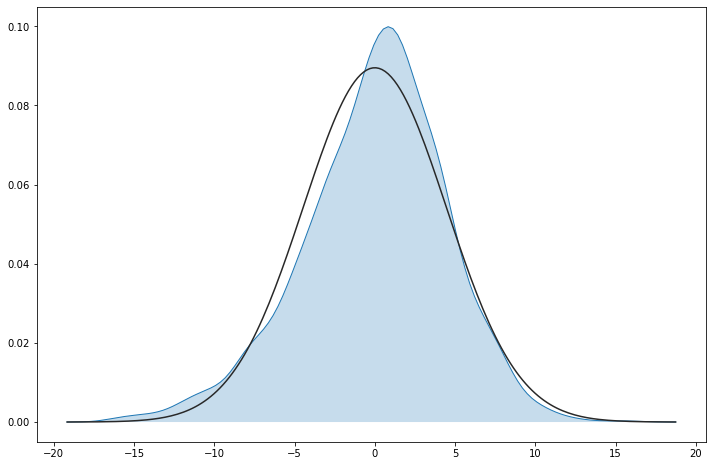

In [13]:
fig = plt.figure(figsize=(12, 8))
ax = sns.distplot(mdf.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = sst.norm)
plt.show()

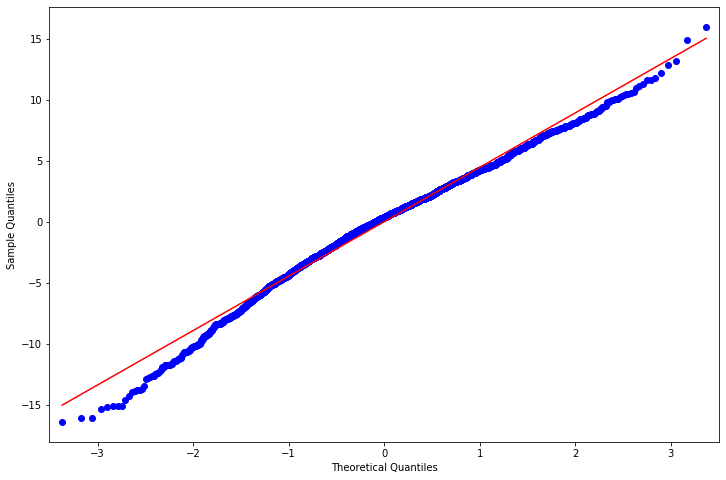

In [14]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = sm.qqplot(mdf.resid, dist = sst.norm, line = 's', ax = ax)
plt.show()

In [15]:
labels = ["Statistic", "p-value"]

norm_res = sst.shapiro(mdf.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)

Statistic 0.9894216060638428
p-value 3.878270317739241e-13


Not bad :)

In [25]:
feature_data = data[['Week', 'Series', 'Order', "Female_celebrity", "Celebrity_BAME", "Age", "Total"]]

feature_data = pd.merge(
    feature_data,
    pd.get_dummies(data["Type"], prefix="Type"),
    left_index=True,
    right_index=True
)

for k in feature_data.keys():
    feature_data[k] = feature_data[k].map(lambda x: string_to_type(x, float))

feature_data = sm.add_constant(feature_data)
feature_data = feature_data.drop("Type_Ballroom", 1)

target_data = np.logical_or(data["Result"] == "Eliminated", data["Result"] == "Bottom two").astype(int)

This is a multilevel logistic regression model that looks at whether the dancers ended up in the bottom two. Since the scores that people get will generally increase week by week and the people ending up in the bottom two are "better" dancers, the different levels of the model are the week numbers in addition to the series numbers this time. 

In [28]:
feature_data_fixed = feature_data[['const', 'Order', 'Female_celebrity', "Celebrity_BAME", 'Age', 'Total',
       'Type_Fusion', 'Type_Latin', 'Type_Speciality']]
feature_data_random = feature_data[["Week", "Series"]]

inds = ~(feature_data_fixed.isnull().any(axis=1))

feature_data = feature_data[inds]
target_data = target_data[inds]
feature_data["Result"] = target_data

logit_model = sm.BinomialBayesMixedGLM.from_formula(
    "Result ~ Order + Female_celebrity + Celebrity_BAME + Age + Total + Type_Fusion + Type_Latin + Type_Speciality",
    {"Week": "1 + Week", "Series": "1 + Series"},
    feature_data
)
logit_res = logit_model.fit_vb(fit_method="BFGS")
print(logit_res.summary())


c:\users\james.rafferty\appdata\local\programs\python\python38\lib\site-packages\statsmodels\genmod\bayes_mixed_glm.py:1068: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
c:\users\james.rafferty\appdata\local\programs\python\python38\lib\site-packages\statsmodels\genmod\bayes_mixed_glm.py:1068: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))


                  Binomial Mixed GLM Results
                 Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
---------------------------------------------------------------
Intercept           M     1.7965   0.0639                      
Order               M    -0.0955   0.0116                      
Female_celebrity    M     0.2253   0.0894                      
Celebrity_BAME      M     0.4932   0.1447                      
Age                 M     0.0120   0.0016                      
Total               M    -0.2363   0.0022                      
Type_Fusion         M    -0.2257   1.0502                      
Type_Latin          M    -0.3827   0.1063                      
Type_Speciality     M    -0.1118   0.1190                      
Week                V    -0.7488   0.5343 0.473   0.162   1.377
Series              V    -1.6806   0.7811 0.186   0.039   0.888
Parameter types are mean structure (M) and variance structure
(V)
Variance parameters are modeled as log standard deviation

In [29]:
np.exp(0.2253)

1.2526984693668801

In [30]:
np.exp(0.4932)

1.6375479982400416

Women are 25% more likely and BAME people are 64% more likely to be in the dance off, despite both groups getting higher scores from the judges.